In [53]:
from joblib import Parallel, delayed
import multiprocessing
import numpy as np
import pandas as pd

import sys
sys.path.append('../')
from src import *

In [54]:
PATH_DATA = '/home/disij/projects/acdc/data/'
OUTPUT_DIR = "/extra/disij0/data/flow_cytometry/flowMP_output/"
PATH_SAMPLES = OUTPUT_DIR + "AML_corrected_table_accepted_samples"
FILENAME_PREDICTIONS = OUTPUT_DIR + "AML_corrected_table_predictions.csv.gz"

Load AML dataset from [ACDC paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5447237/pdf/btx054.pdf)...

In [55]:
# load AML data and table

### LOAD DATA ###
path = PATH_DATA + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, \
                 compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']

table = table.fillna(0)
X = df[channels].values
table_headers = list(table)

### transform data
data = np.arcsinh((X-1.)/5.)
N, d = data.shape
emp_bounds = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])
ct2idx = {x:i for i,x in enumerate(table.index)}
idx2ct = [key for idx, key in enumerate(table.index)]
Y = np.array([ct2idx[_] for _ in df.cell_type])

# rename table header 'HLA-DR' to 'HLADR' to prevent error from '-'
temp_headers = list(table)
temp_headers[29] = "HLADR"
table.columns = temp_headers

There is a mistake in the prior information table, here I change the response of Mature B cells to marker CD38 from "0" to "-1.0" and classify cells based on the corrected table, and write predictions to file...

In [56]:
table.at['Mature B cells','CD38'] = -1.0

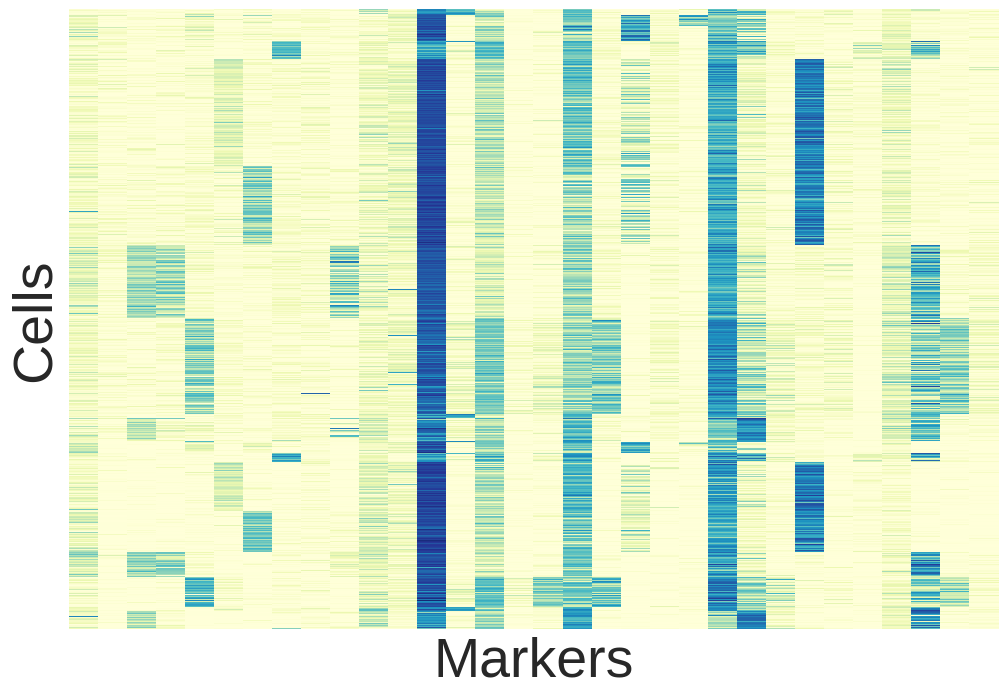

In [57]:
# plot heatmap
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.cm as cm


fig, ax = plt.subplots()
f = lambda x: np.arcsinh((x -1.)/5.)
vmin=df[channels].applymap(f).values.min()
vmax=df[channels].applymap(f).values.max()
normalize = lambda x: (x-vmin)/(vmax-vmin)
#cmap = sns.diverging_palette(150, 275, sep=20, as_cmap=True)
#cmap = sns.diverging_palette(250, 10, sep=20, as_cmap=True)
#cmap = sns.diverging_palette(150, 10, sep=20, as_cmap=True)
cmap="YlGnBu"

ax = sns.heatmap(df[channels].applymap(f).applymap(normalize),xticklabels=False,yticklabels=False,cmap=cmap,\
                 cbar = False,ax = ax)
ax.set_xlabel("Markers",fontsize=40)
ax.set_ylabel("Cells",fontsize=40)

fig.set_size_inches(12, 8)
plt.savefig('../output/plots/AML_data_heatmap.png')
plt.show()

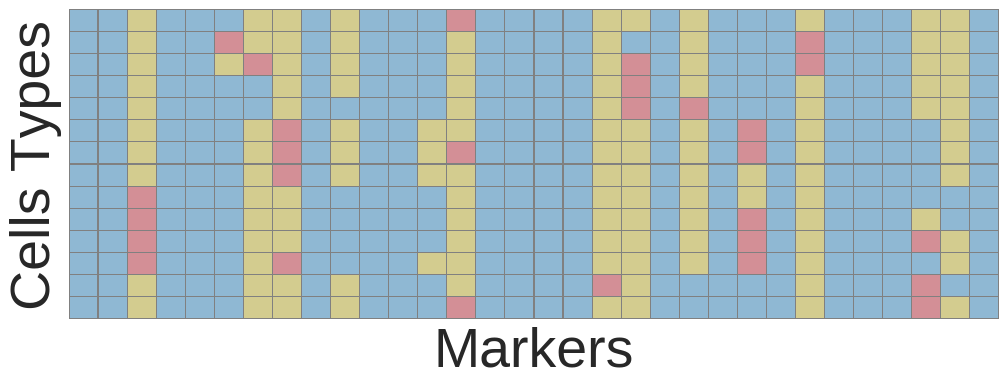

In [117]:
# plot heatmap
sns.set(font_scale=4)
fig, ax = plt.subplots()
from matplotlib.colors import LinearSegmentedColormap
# cmap = [[ 0.26613466,  0.47369811,  0.7317616 ,  1.        ], \
#         [ 1,  1 ,  1,  1.        ], \
#         [ 0.85453713,  0.22957019,  0.27623218,  1.        ]]
# cmap = [[ 68./255, 163./255, 136./255 ,  1.        ], \
#         [1,  1 ,  1,  1.        ], \
#         [ 139./255, 111./255, 232./255,  1.        ]]
# cmap = [[ 212./256,205./256,144./256 ,  1], \
#         [ 144./256,185./256,212./256,  1.], \
#         [ 212./256,144./256,151./256 ,  1]]
cmap = [[ 212./256,205./256,144./256 ,  1], \
        [ 144./256,185./256,212./256,  1.], \
        [ 212./256,144./256,151./256 ,  1]]
cmap = LinearSegmentedColormap.from_list('Custom', cmap, len(cmap))
# cmap = "YlGnBu"
# cmap = "YlOrBr"
# cmap = "bwr"
# cmap = "seismic"
# cmap = "coolwarm"
# cmap = "RdYlGn"
# cmap = 'RdBu'
# cmap = 'terrain'
sns.heatmap(table.values.astype(int), annot=True, fmt='f', cmap=cmap, \
            linewidths=.1, linecolor='gray',\
            xticklabels=False,yticklabels=False,ax = ax ,cbar = False )

# Manually specify colorbar labelling after it's been generated
# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([-0.667, 0, 0.667])
# colorbar.set_ticklabels(['-1: Low','0: Irrelevant','+1: High'])

ax.set_xlabel("Markers",fontsize=40)
ax.set_ylabel("Cells Types",fontsize=40)

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)
fig.set_size_inches(12, 4)
plt.savefig('../output/plots/AML-table_heatmap.png')
plt.show()



# sns.heatmap(table,xticklabels=True,yticklabels=False,cmap = "Blues",\
#             cbar=True,annot=True, fmt="d",vmin=-1.0, vmax=1.0,ax = ax)

